# IMRPhenomD test

## Example of NaN

In [65]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt
from jax import grad, vmap
from functools import partial
jax.config.update("jax_enable_x64", True)

params = {"axes.grid": True,
          "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)

In [47]:
# Some very specific number for mass, for which NaN was observed
m = 2.212299314305308 # mass in solar masses
m1 = m
m2 = m

chi = 0.0 # z-component spin
chi1 = chi 
chi2 = chi

In [48]:
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0.2 # Polarization angle

# Generate frequency grid
f_l = 24
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

In [49]:
# Nudge (or do not nudge) m2 param to be sufficiently unequal to m1, and show strain from ripple
for eps in [0, 1e-8]:
    print(f"eps: {eps}")
    m2 = m1 - eps
    Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
    theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
    hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta_ripple, f_ref)
    print("Ripple waveform hplus:")
    print(hp_ripple)

eps: 0
Ripple waveform hplus:
[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
eps: 1e-08
Ripple waveform hplus:
[ 7.42828575e-24+0.00000000e+00j -7.21398062e-24+1.75610851e-24j
  6.57968567e-24-3.43209113e-24j ... -1.76984612e-25-3.78634738e-26j
 -1.76955897e-25-3.79751181e-26j -1.76927113e-25-3.80867349e-26j]


## More detailed study

Sample masses, fix $m2 = m1$ and check if the result gives NaNs.

In [50]:
def generate_waveform(theta):
    return IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta, f_ref)
generate_waveform_jit = jax.jit(generate_waveform)

Number of times NaNs observed: 2050 (20.5 % of samples)


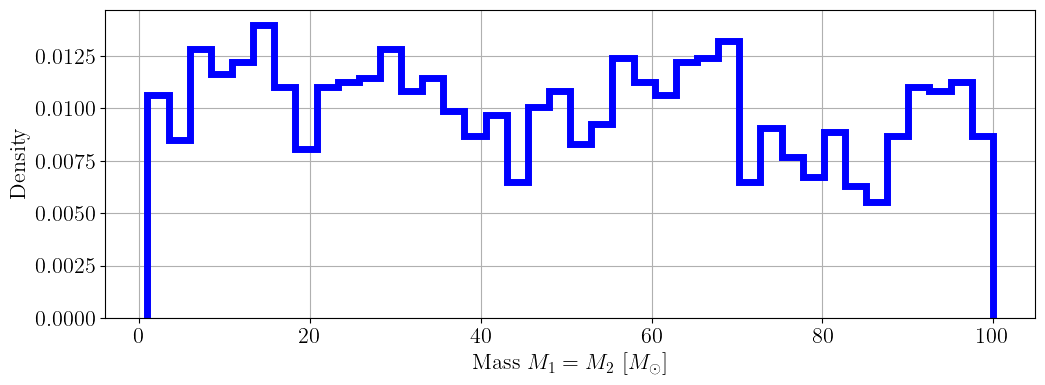

In [71]:
n_tests = 10000
counter = 0

m_nans = []

for i in range(n_tests):
    m1 = np.random.uniform(1, 100)
    m2 = m1
    Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
    theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])
    hp, hx = generate_waveform_jit(theta_ripple)
    if np.isnan(np.array(hp)).any():
        m_nans.append(m1)
        counter += 1
        
print(f"Number of times NaNs observed: {counter} ({100 * counter/n_tests} % of samples)")

plt.figure(figsize = (12, 4))
plt.hist(m_nans, bins = 40, histtype='step', color="blue", linewidth=5, density=True)
plt.xlabel(r"Mass $M_1 = M_2$ [$M_{\odot}$]")
plt.ylabel(r"Density")
plt.show()

In [72]:
print("Array of mass giving Nans:")
print(m_nans)

Array of mass giving Nans:
[44.53577397451648, 98.54936614909377, 67.26876915820067, 92.50761064441865, 36.89126092278041, 35.66346404871277, 94.26292784295701, 16.33633530641209, 68.00281595205912, 21.229914602072625, 68.01606726137932, 47.61743239930682, 49.37336048330706, 47.644838954921276, 85.03636170598594, 64.3537724783185, 24.604163800312193, 35.73509382311632, 22.57763140610828, 7.010392493299522, 54.43296868542058, 69.38926771531447, 34.50456786781347, 9.864640346961174, 77.46874823673222, 18.095689826140145, 86.96581257619466, 73.87551436398526, 36.03570799368487, 11.347706293439904, 23.10354788436095, 27.596125096313532, 15.233806729370755, 42.924251593748316, 11.228396199639931, 6.020657101209838, 13.600902545397746, 34.24556559917531, 73.45046432372389, 80.30609380863011, 88.87902895728926, 32.88177483896038, 57.20826412966117, 23.547812562496812, 91.34902124730424, 23.727782432621378, 35.73055914584488, 31.759907113235315, 36.50677401212915, 65.29650347370702, 62.8542500